<a href="https://colab.research.google.com/github/chaewoncutie/final-code-pls-run/blob/main/GMM_K%3D20_with_cluster_profiling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install dependencies
!pip install -U scikit-learn nltk pandas matplotlib seaborn scipy ipywidgets umap-learn hdbscan

In [2]:
import pandas as pd
import re
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, adjusted_rand_score, normalized_mutual_info_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.mixture import GaussianMixture
import numpy as np
import umap
from google.colab import files
from sklearn.metrics.pairwise import cosine_similarity
from IPython.display import display

In [3]:
# Download necessary NLTK data
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [4]:
# Upload the JSON file
uploaded = files.upload()

# Read the JSON file
file_name = next(iter(uploaded))
df = pd.read_json(file_name, lines=True)

# Data Cleaning and Preprocessing
print(f"Number of rows in original dataset: {df.shape[0]}")
print(f"Number of columns in original dataset: {df.shape[1]}")
display(df.head())

df = df.applymap(lambda x: None if isinstance(x, str) and x.strip() == '' else x.strip() if isinstance(x, str) else x)
print(f"Null values in each column:\n{df.isnull().sum()}")
print(f"Number of duplicated rows: {df.duplicated().sum()}")

df = df.dropna(subset=['headline', 'short_description'])
df = df.drop_duplicates()
df = df[df['date'].dt.year.isin(range(2017, 2023))]
print(f"Number of rows after cleaning: {df.shape[0]}")
print(f"Number of columns after cleaning: {df.shape[1]}")

df['text'] = df[['headline', 'short_description']].astype(str).apply(lambda x: ' '.join(x), axis=1)

Saving News_Category_Dataset_v3.json to News_Category_Dataset_v3 (1).json
Number of rows in original dataset: 209527
Number of columns in original dataset: 6


,link,headline,category,short_description,authors,date
0,https://www.huffpost.com/entry/covid-boosters-...,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS,Health experts said it is too early to predict...,"Carla K. Johnson, AP",2022-09-23
1,https://www.huffpost.com/entry/american-airlin...,"American Airlines Flyer Charged, Banned For Li...",U.S. NEWS,He was subdued by passengers and crew when he ...,Mary Papenfuss,2022-09-23
2,https://www.huffpost.com/entry/funniest-tweets...,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY,"""Until you have a dog you don't understand wha...",Elyse Wanshel,2022-09-23
3,https://www.huffpost.com/entry/funniest-parent...,The Funniest Tweets From Parents This Week (Se...,PARENTING,"""Accidentally put grown-up toothpaste on my to...",Caroline Bologna,2022-09-23
4,https://www.huffpost.com/entry/amy-cooper-lose...,Woman Who Called Cops On Black Bird-Watcher Lo...,U.S. NEWS,Amy Cooper accused investment firm Franklin Te...,Nina Golgowski,2022-09-22


<ipython-input-4-a4f9f06a9c59>:13: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: None if isinstance(x, str) and x.strip() == '' else x.strip() if isinstance(x, str) else x)


Null values in each column:
link                     0
headline                 6
category                 0
short_description    19712
authors              37418
date                     0
dtype: int64
Number of duplicated rows: 13
Number of rows after cleaning: 47010
Number of columns after cleaning: 6


In [5]:
# Text Preprocessing
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove punctuation & numbers
    text = re.sub(r'\btrump\b', '', text)  # Remove "trump"
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    return text

df['processed_text'] = df['text'].apply(preprocess_text)

In [6]:
# Tokenization, Stopword Removal, and Lemmatization
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def tokenize_and_lemmatize(text):
    return ' '.join([lemmatizer.lemmatize(word) for word in word_tokenize(text) if word not in stop_words])

df['filtered_text'] = df['processed_text'].apply(tokenize_and_lemmatize)

In [7]:
# TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english', max_df=0.6, min_df=3, ngram_range=(1,3))
X = vectorizer.fit_transform(df['filtered_text'])

In [8]:
# Dimensionality Reduction
svd = TruncatedSVD(n_components=min(X.shape[1], 3000), random_state=42)
X_svd = svd.fit_transform(X).astype(np.float32)

explained_variance = svd.explained_variance_ratio_.sum()
print(f"Total explained variance by selected components: {explained_variance:.4f}")

Total explained variance by selected components: 0.8785


In [14]:
# UMAP for further dimensionality reduction
umap_model = umap.UMAP(n_components=2, n_neighbors=30, min_dist=0.3, random_state=42)
X_umap = umap_model.fit_transform(X_svd)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [19]:
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X_umap)

In [23]:
num_clusters = 20
gmm = GaussianMixture(n_components=num_clusters, covariance_type='full', random_state=42)
labels_gmm = gmm.fit_predict(X_normalized)
df['cluster_gmm'] = labels_gmm

gmm_metrics = {
    'silhouette': silhouette_score(X_normalized, labels_gmm),
    'davies_bouldin': davies_bouldin_score(X_normalized, labels_gmm),
    'calinski_harabasz': calinski_harabasz_score(X_normalized, labels_gmm),
    'similarity': np.mean(cosine_similarity(X_normalized[:1000]))
}

print("GMM Clustering Metrics:")
for key, value in gmm_metrics.items():
    print(f"{key}: {value:.4f}")

GMM Clustering Metrics:
silhouette: 0.3070
davies_bouldin: 0.7875
calinski_harabasz: 24556.2852
similarity: 0.4007


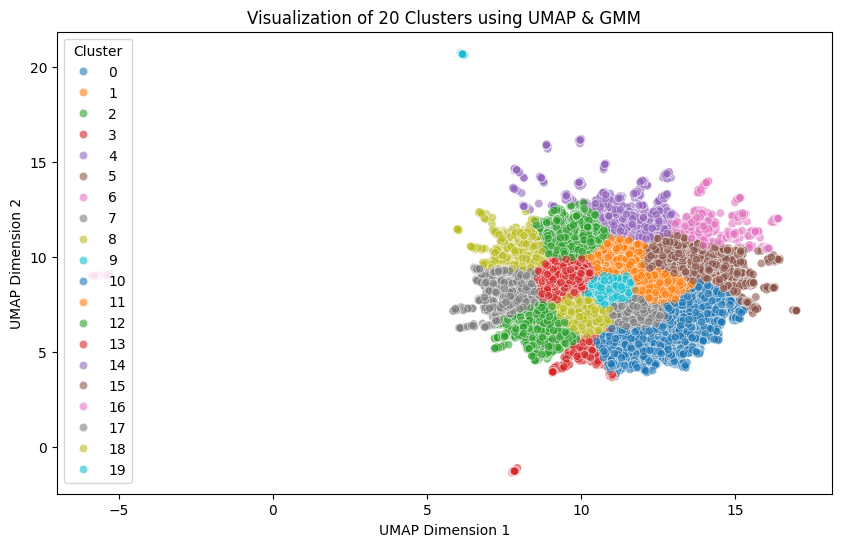

In [24]:
# Visualizing Clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_umap[:, 0], y=X_umap[:, 1], hue=labels_gmm, palette='tab10', alpha=0.6)
plt.title(f'Visualization of {num_clusters} Clusters using UMAP & GMM')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.legend(title='Cluster')
plt.show()

In [25]:
# Cluster Profiling for GMM
print(f"Cluster Profiles for GMM with {num_clusters} Clusters")

for cluster_num in range(num_clusters):
    cluster_data = df[df['cluster_gmm'] == cluster_num]

    if cluster_data.empty:
        print(f"Cluster {cluster_num} is empty.")
        continue

    most_common_words = pd.Series(' '.join(cluster_data['filtered_text']).split()).value_counts().head(10)

    print(f"\nCluster {cluster_num}:")
    print(most_common_words)
    print("-" * 40)

Cluster Profiles for GMM with 20 Clusters

Cluster 0:
new            575
said           549
president      448
say            369
coronavirus    365
u              359
people         338
covid          331
biden          303
trump          264
Name: count, dtype: int64
----------------------------------------

Cluster 1:
new       390
people    314
year      276
one       275
u         263
say       254
woman     251
time      231
like      190
first     180
Name: count, dtype: int64
----------------------------------------

Cluster 2:
trump        400
donald       386
president    358
colbert      279
say          266
show         262
house        259
stephen      254
clinton      214
said         198
Name: count, dtype: int64
----------------------------------------

Cluster 3:
trump        524
donald       448
house        380
president    374
say          360
white        337
new          326
u            312
people       276
said         273
Name: count, dtype: int64
-------------